<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s3e25?scriptVersionId=162291807" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2022/11/Mohs-Hardness-Scale.png?ssl=1)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv
/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv
/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


# <span style="color: ForestGreen">Table of Contents</span>

1. [Import libraries](#1)
2. [Open data files](#2)
3. [Show first 5 lines of train data](#3)
    - 3.1 [Compare original train and competition train](#3.1)
    - 3.2 [Concatenate original train with competition train](#3.2)
    - 3.3 [3.3 Feature Engineering](#3.3)
4. [Shapes of train and test data](#4)
5. [Display descriptive statistics of train data](#5)
6. [Check the number of gaps for each feature](#6)
7. [Data types of training set](#7)
    - 7.1 [Figure out how much duplicates in data](#7.1)
    - 7.2 [Remove duplicates from train data](#7.2)
8. [Display histograms of distribution](#8)
9. [Let's count target of train data](#9)
10. [Transorm the data with logarithm](#10)
    - 10.1 [Pie plot of smoking](#10.1)
    - 10.2 [Feature importance](#10.2)
11. [Build a heat map of correlations](#11)
12. [Define base models](#12)
13. [Defining the meta-model](#13)
14. [Creating and fitting the stacking model](#14)
15. [Predict the validation set and calculate Median Absolute Error score](#15)
16. [Predict on the test data](#16)
17. [Build DataFrame and make first submission](#17)


<font face="Bahnschrift Condensed" style="font-size: 14pt;">Hardness, or the quantitative value of resistance to permanent or plastic deformation, plays a very crucial role in materials design in many applications, such as ceramic coatings and abrasives. Hardness testing is an especially useful method as it is non-destructive and simple to implement to gauge the plastic properties of a material. In this study, I proposed a machine, or statistical, learning approach to predict hardness in naturally occurring materials, which integrates atomic and electronic features from composition directly across a wide variety of mineral compositions and crystal systems. First, atomic and electronic features from the composition, such as van der Waals and covalent radii as well as the number of valence electrons, were extracted from the composition.
</font>
<br><br>
<font face="Bahnschrift Condensed" style="font-size: 14pt;">In this study, the author trained a set of classifiers to understand whether compositional features can be used to predict the Mohs hardness of minerals of different chemical spaces, crystal structures, and crystal classes. The dataset for training and testing the classification models used in this study originated from experimental Mohs hardness data, their crystal classes, and chemical compositions of naturally occurring minerals reported in the Physical and Optical Properties of Minerals CRC Handbook of Chemistry and Physics and the American Mineralogist Crystal Structure Database. The database is composed of 369 uniquely named minerals. Due to the presence of multiple composition combinations for minerals referred to by the same name, the first step was to perform compositional permutations on these minerals. This produced a database of 622 minerals of unique compositions, comprising 210 monoclinic, 96 rhombohedral, 89 hexagonal, 80 tetragonal, 73 cubic, 50 orthorhombic, 22 triclinic, 1 trigonal, and 1 amorphous structure. An independent dataset was compiled to validate the model performance. The validation dataset contains the composition, crystal structure, and Mohs hardness values of 51 synthetic single crystals reported in the literature. The validation dataset includes 15 monoclinic, 7 tetragonal, 7 hexagonal, 6 orthorhombic, 4 cubic, and 3 rhombohedral crystal structures.
</font>
<br><br>
<font face="Bahnschrift Condensed" style="font-size: 14pt;">In this study, the author constructed a database of compositional feature descriptors that characterize naturally occurring materials obtained directly from the Physical and Optical Properties of Minerals CRC Handbook45. This comprehensive compositional-based dataset allows us to train models that are able to predict hardness across a wide variety of mineral compositions and crystal classes. Each material in both the naturally occurring mineral and artificial single crystal datasets was represented by 11 atomic descriptors. The elemental features are the number of electrons, number of valence electrons, atomic number, Pauling electronegativity of the most common oxidation state, covalent atomic radii, van der Waals radii, and ionization energy of neutral.


![](https://i0.wp.com/www.trigonalsystem.com/wp-content/uploads/2021/05/07.jpg?resize=1024%2C606&ssl=1)

<a id='1'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧱 1 - Import libraries</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import median_absolute_error

<a id='2'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧰 2 - Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv')

train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

<a id='3'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🔨 3 - Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


<a id='3.1'></a>
### <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">3.1 Compare original train and competition train</span>

In [5]:
print(original_train.shape)
original_train.columns.tolist()

(622, 13)


['Unnamed: 0',
 'Hardness',
 'allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average']

In [6]:
print(train.shape)
train.columns.tolist()

(10407, 13)


['id',
 'allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness']

<a id='3.2'></a>
### <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">3.2 Concatenate original train with competition train</span>

In [7]:
train = pd.concat(objs=[train, original_train]).reset_index(drop=True)
train.shape

(11029, 14)

In [8]:
train.columns.tolist()

['id',
 'allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness',
 'Unnamed: 0']

In [9]:
train = train.drop(['id', 'Unnamed: 0'], axis=1)
test.drop(columns='id', axis=1, inplace=True)
train.columns.tolist()

['allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness']

<a id='3.3'></a>
### <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">3.3 Feature Engineering</span>

In [10]:
# Electronegativity Difference
train['n_electronegativity_diff'] = train['el_neg_chi_Average'] - train['atomicweight_Average']
train['n_electronegativity_diff'].replace([np.inf, -np.inf], train['n_electronegativity_diff'].max(), inplace=True)
train['n_electronegativity_diff'].fillna(train['n_electronegativity_diff'].median(), inplace=True)

test['n_electronegativity_diff'] = test['el_neg_chi_Average'] - test['atomicweight_Average']
test['n_electronegativity_diff'].replace([np.inf, -np.inf], test['n_electronegativity_diff'].max(), inplace=True)
test['n_electronegativity_diff'].fillna(test['n_electronegativity_diff'].median(), inplace=True)

# Density Difference
train['Density Difference'] = train['density_Total'] - train['density_Average']
train['Density Difference'].replace([np.inf, -np.inf], train['Density Difference'].max(), inplace=True)
train['Density Difference'].fillna(train['Density Difference'].median(), inplace=True)

test['Density Difference'] = test['density_Total'] - test['density_Average']
test['Density Difference'].replace([np.inf, -np.inf], test['Density Difference'].max(), inplace=True)
test['Density Difference'].fillna(test['Density Difference'].median(), inplace=True)

# Последняя проверка на NaN (можно убрать, если не нужно)
print(train.isnull().sum(), end='\n\n\n')
print(test.isnull().sum())

train.describe()

allelectrons_Total          0
density_Total               0
allelectrons_Average        0
val_e_Average               0
atomicweight_Average        0
ionenergy_Average           0
el_neg_chi_Average          0
R_vdw_element_Average       0
R_cov_element_Average       0
zaratio_Average             0
density_Average             0
Hardness                    0
n_electronegativity_diff    0
Density Difference          0
dtype: int64


allelectrons_Total          0
density_Total               0
allelectrons_Average        0
val_e_Average               0
atomicweight_Average        0
ionenergy_Average           0
el_neg_chi_Average          0
R_vdw_element_Average       0
R_cov_element_Average       0
zaratio_Average             0
density_Average             0
n_electronegativity_diff    0
Density Difference          0
dtype: int64


,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness,n_electronegativity_diff,Density Difference
count,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000
mean,138.478018,15.245564,16.907728,4.539603,37.210823,10.947921,2.608727,1.727907,0.940243,0.494563,2.121260,4.645257,-34.602096,13.124303
std,300.368288,18.357166,10.453091,0.698567,25.961319,1.430073,0.339107,0.197129,0.181762,0.065491,1.937599,1.683270,26.066262,17.910458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-165.610000,-8.857169
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.599905,2.530000,1.672500,0.864000,0.476196,0.812440,3.000000,-46.049500,6.101748
50%,100.000000,11.073072,12.500000,4.700000,26.164726,11.221459,2.706000,1.732000,0.914286,0.489272,1.345930,5.500000,-23.358827,8.504760
75%,138.000000,17.590000,21.833333,4.800000,48.719500,11.688350,2.805000,1.797813,0.980000,0.496606,2.732000,6.000000,-17.543893,14.740322
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000,2.727000,642.690610


<a id='4'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">💎 4 - Shapes of train and test data</span>

In [11]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (11029, 14)
Test data: (6939, 13)

Train data consists of 61.38% of all observations
Test data consists of 38.62% of all observations


<a id='5'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🏭 5 - Display descriptive statistics of train data</span>

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,11029.0,138.478018,300.368288,0.000000,68.000000,100.000000,138.000000,15300.000000
density_Total,11029.0,15.245564,18.357166,0.000000,7.558488,11.073072,17.590000,643.093804
allelectrons_Average,11029.0,16.907728,10.453091,0.000000,10.000000,12.500000,21.833333,67.000000
val_e_Average,11029.0,4.539603,0.698567,0.000000,4.000000,4.700000,4.800000,6.000000
atomicweight_Average,11029.0,37.210823,25.961319,0.000000,20.298893,26.164726,48.719500,167.400000
ionenergy_Average,11029.0,10.947921,1.430073,0.000000,10.599905,11.221459,11.688350,15.245810
el_neg_chi_Average,11029.0,2.608727,0.339107,0.000000,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,11029.0,1.727907,0.197129,0.000000,1.672500,1.732000,1.797813,2.250000
R_cov_element_Average,11029.0,0.940243,0.181762,0.000000,0.864000,0.914286,0.980000,1.615840
zaratio_Average,11029.0,0.494563,0.065491,0.000000,0.476196,0.489272,0.496606,0.825990


#### <span style="color: ForestGreen">allelectrons_Total, density_Total features here contain several values ​​that are much greater than the 3rd quantile</span>

<a id='6'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧱 6 - Check the number of gaps for each feature</span>

![](https://civileblog.com/wp-content/uploads/2016/06/rock-test.jpg)

In [13]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(train.isna().sum())

TRAIN data

allelectrons_Total          0
density_Total               0
allelectrons_Average        0
val_e_Average               0
atomicweight_Average        0
ionenergy_Average           0
el_neg_chi_Average          0
R_vdw_element_Average       0
R_cov_element_Average       0
zaratio_Average             0
density_Average             0
Hardness                    0
n_electronegativity_diff    0
Density Difference          0
dtype: int64



TEST data

allelectrons_Total          0
density_Total               0
allelectrons_Average        0
val_e_Average               0
atomicweight_Average        0
ionenergy_Average           0
el_neg_chi_Average          0
R_vdw_element_Average       0
R_cov_element_Average       0
zaratio_Average             0
density_Average             0
Hardness                    0
n_electronegativity_diff    0
Density Difference          0
dtype: int64


#### <span style="color: ForestGreen">As we can see, there are no preliminary gaps in the data. However, sometimes it is useful to check the unique values ​​for each characteristic. After all, the gaps could be filled with a '?' and then the .isna() method will not notice them</span>

<a id='7'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧰 7 - Data types of training set</span>

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11029 entries, 0 to 11028
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   allelectrons_Total        11029 non-null  float64
 1   density_Total             11029 non-null  float64
 2   allelectrons_Average      11029 non-null  float64
 3   val_e_Average             11029 non-null  float64
 4   atomicweight_Average      11029 non-null  float64
 5   ionenergy_Average         11029 non-null  float64
 6   el_neg_chi_Average        11029 non-null  float64
 7   R_vdw_element_Average     11029 non-null  float64
 8   R_cov_element_Average     11029 non-null  float64
 9   zaratio_Average           11029 non-null  float64
 10  density_Average           11029 non-null  float64
 11  Hardness                  11029 non-null  float64
 12  n_electronegativity_diff  11029 non-null  float64
 13  Density Difference        11029 non-null  float64
dtypes: flo

#### <span style="color: ForestGreen">As You can see, all data types are numeric, so if there are gaps, they were most likely filled with some kind of numeric values ​​like 0, median or average value</span>

<a id="7.1"></a>
### <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">7.1 Figure out how much duplicates in data</span>

In [15]:
train_duplicates_number = train[train.duplicated()]
                             
print(len(train_duplicates_number))

23


#### <span style="color: ForestGreen">There are 23 duplicates in train data. Let's remove them!</span>

<a id="7.2"></a>
### <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">7.2 Remove duplicates from train data</span>

In [16]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
duplicates = train[train.duplicated()]
len(duplicates)

0

<a id='8'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🔨 8 - Display histograms of distribution</span>

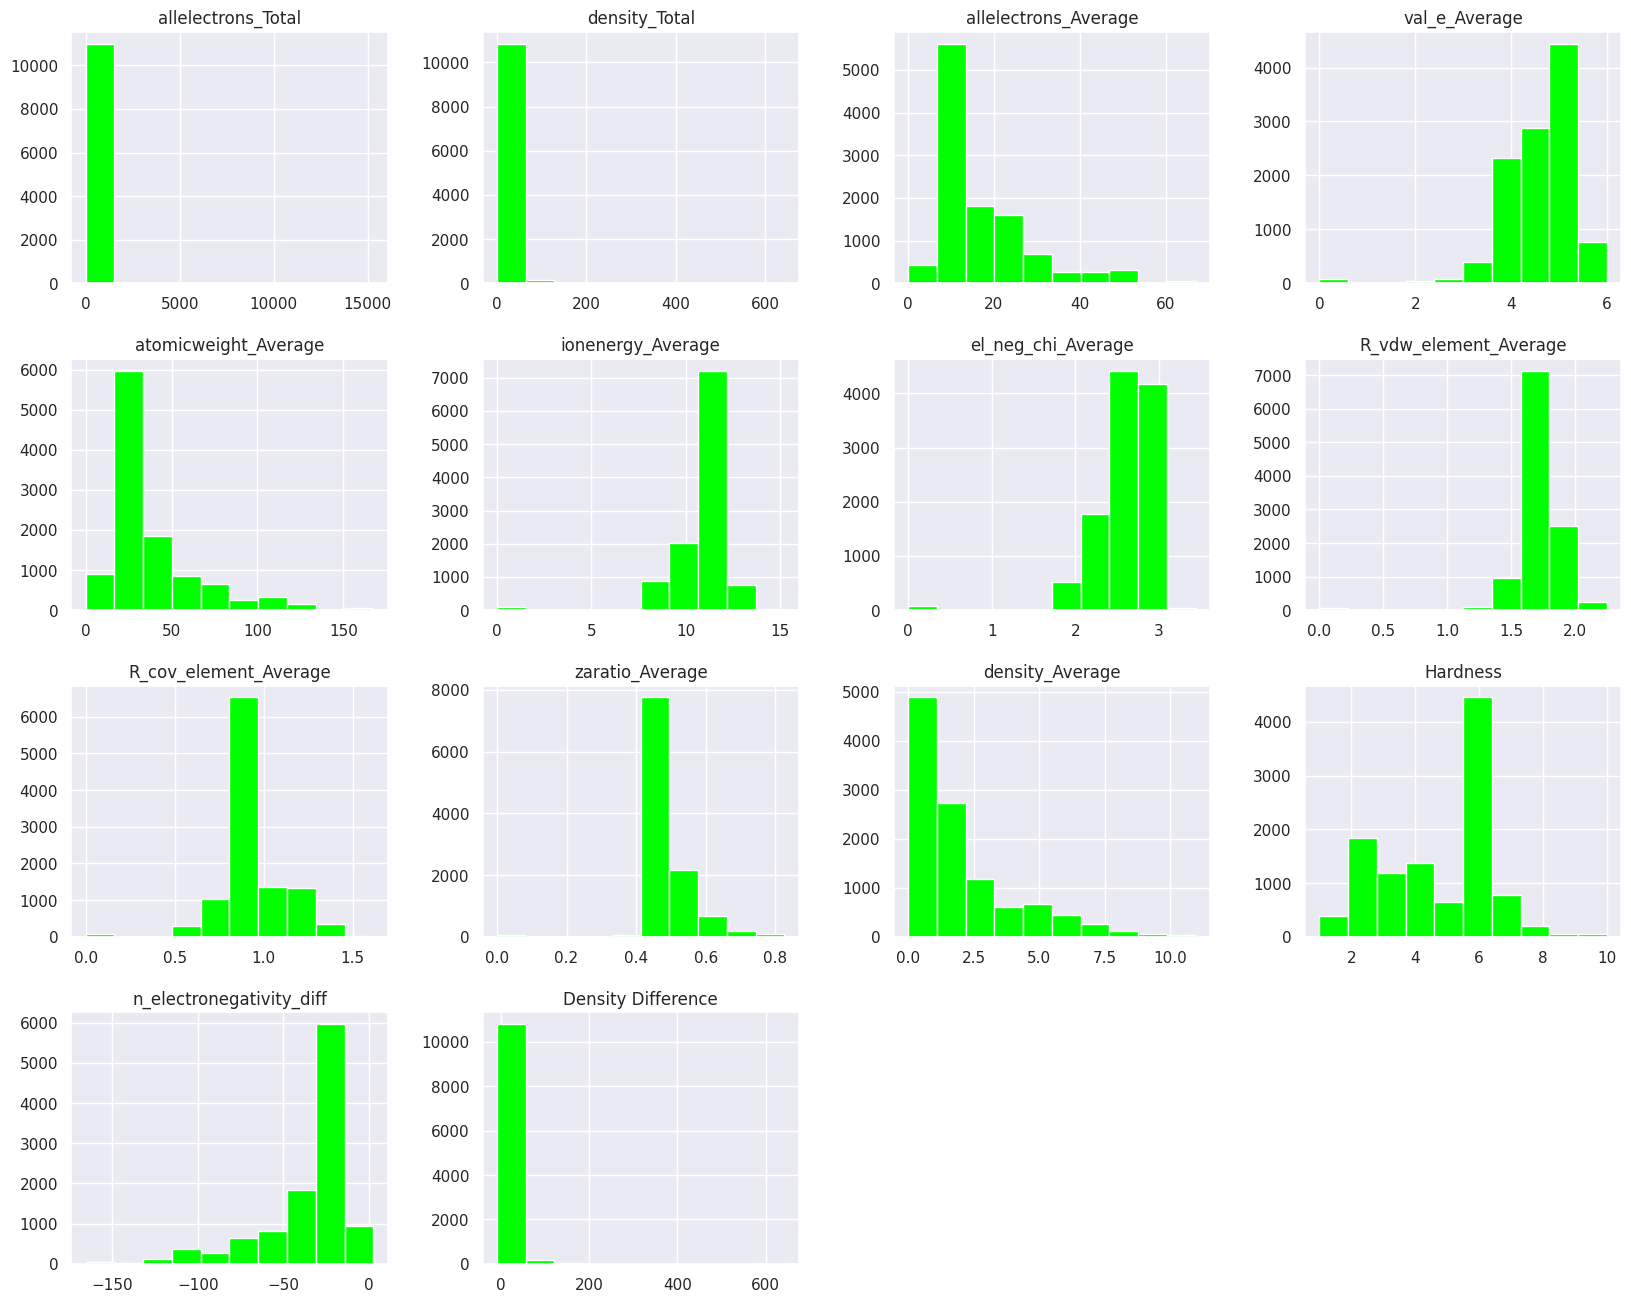

In [17]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='Lime');

<a id='9'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">💎 9 - Let's count target of train data</span>

In [18]:
print(f'{train.Hardness.value_counts()}\n\n')
print(train.Hardness.value_counts() / train.shape[0])

Hardness
6.00     2128
5.50     1573
2.50     1126
3.80      741
5.80      449
6.50      418
2.80      415
2.00      412
5.00      392
4.00      380
3.00      321
2.30      307
3.50      291
6.30      281
6.80      254
1.50      200
1.80      167
3.30      156
5.30      146
4.30      137
4.80      113
4.50      109
7.00      107
7.50      106
7.80       72
9.00       34
10.00      31
9.50       26
1.30       20
8.50       16
8.00       14
6.20       11
7.30       11
5.75       10
2.90        7
8.10        7
1.00        3
3.60        2
3.20        2
8.30        1
5.40        1
6.70        1
2.60        1
4.10        1
2.20        1
4.70        1
6.40        1
9.80        1
2.10        1
6.64        1
Name: count, dtype: int64


Hardness
6.00     0.193349
5.50     0.142922
2.50     0.102308
3.80     0.067327
5.80     0.040796
6.50     0.037979
2.80     0.037707
2.00     0.037434
5.00     0.035617
4.00     0.034527
3.00     0.029166
2.30     0.027894
3.50     0.026440
6.30     0.025532
6.

<a id='10'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🏭 10 - Transorm the data with MinMax</span>

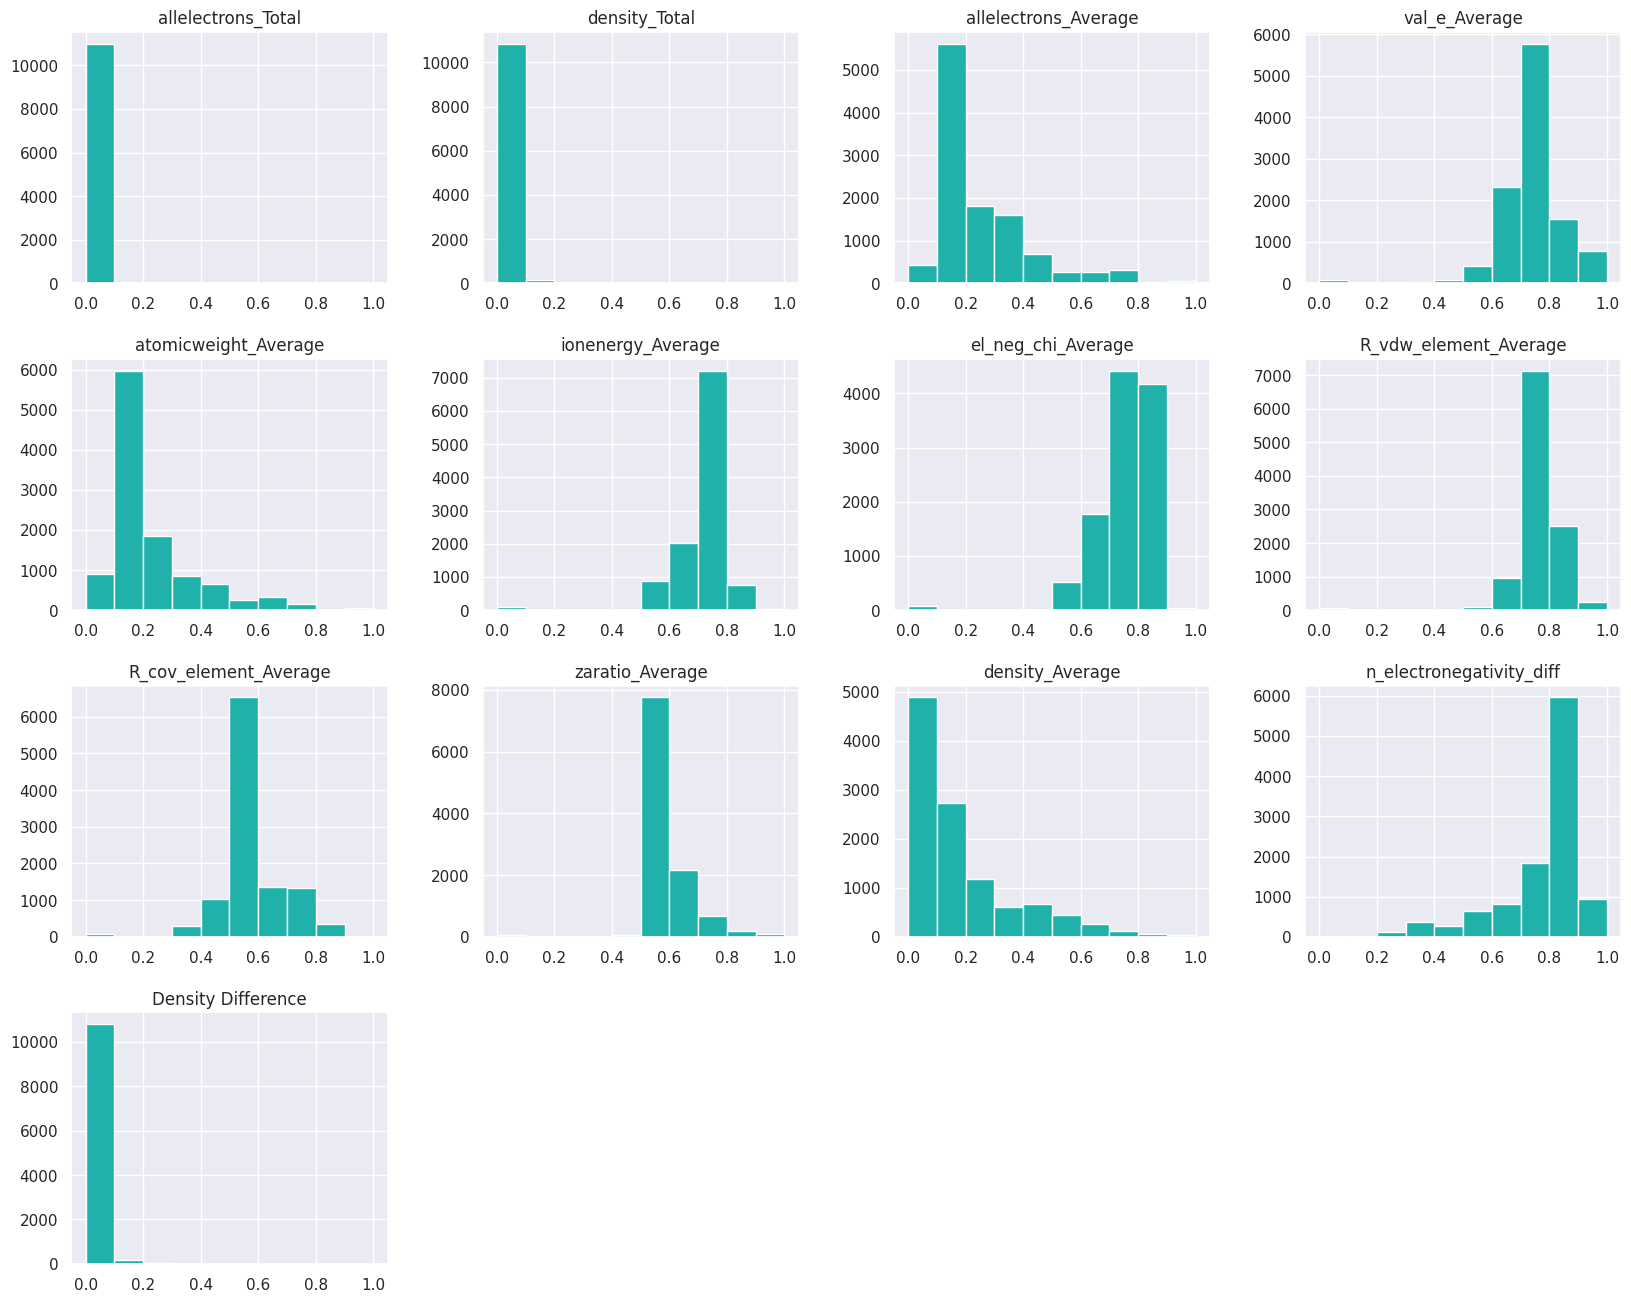

In [19]:
# Split the train data into X and y
X = train.drop(['Hardness'], axis=1)
y = train.Hardness

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: (x - X[column].min()) / (X[column].max() - X[column].min()))

# Transform test data
for column in test.columns.tolist():
    test[column] = test[column].apply(lambda x: (x - test[column].min()) / (test[column].max() - test[column].min()))
    
X.hist(color='LightSeaGreen');

<a id='10.1'></a>
### <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">10.1 - Pie plot of Hardness</span>

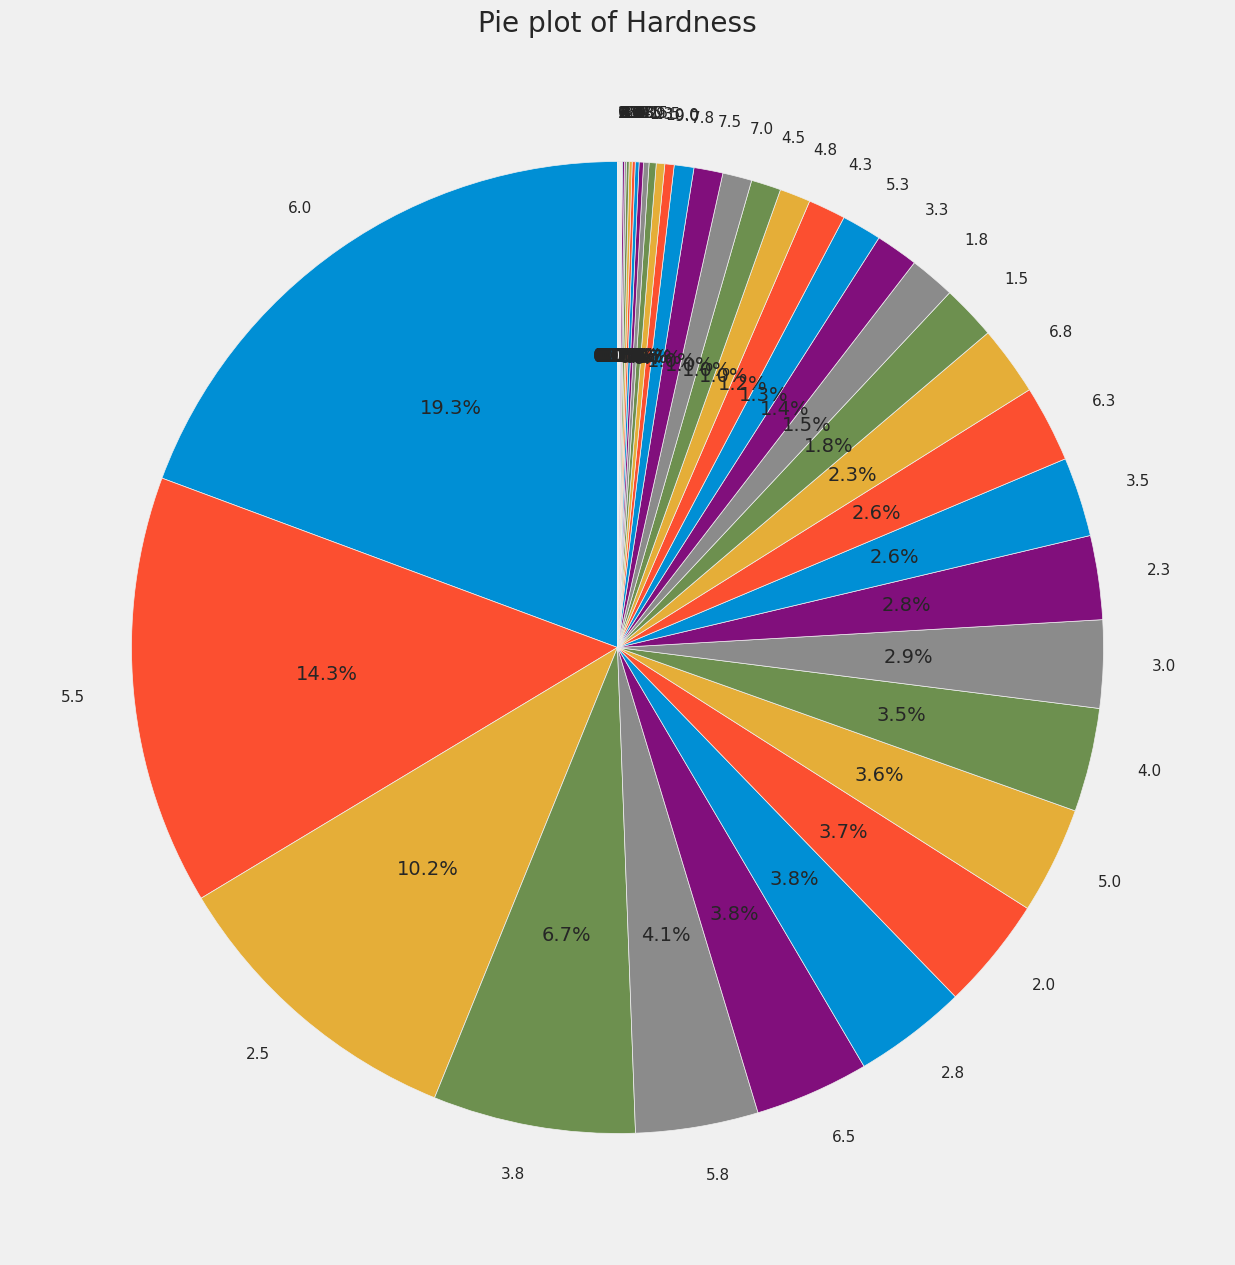

In [20]:
label_counts = y.value_counts()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 15))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie plot of Hardness')
plt.show();

<a id='10.2'></a>
### <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">10.2 Feature importance</span>

CPU times: user 12.1 s, sys: 151 ms, total: 12.2 s
Wall time: 12 s


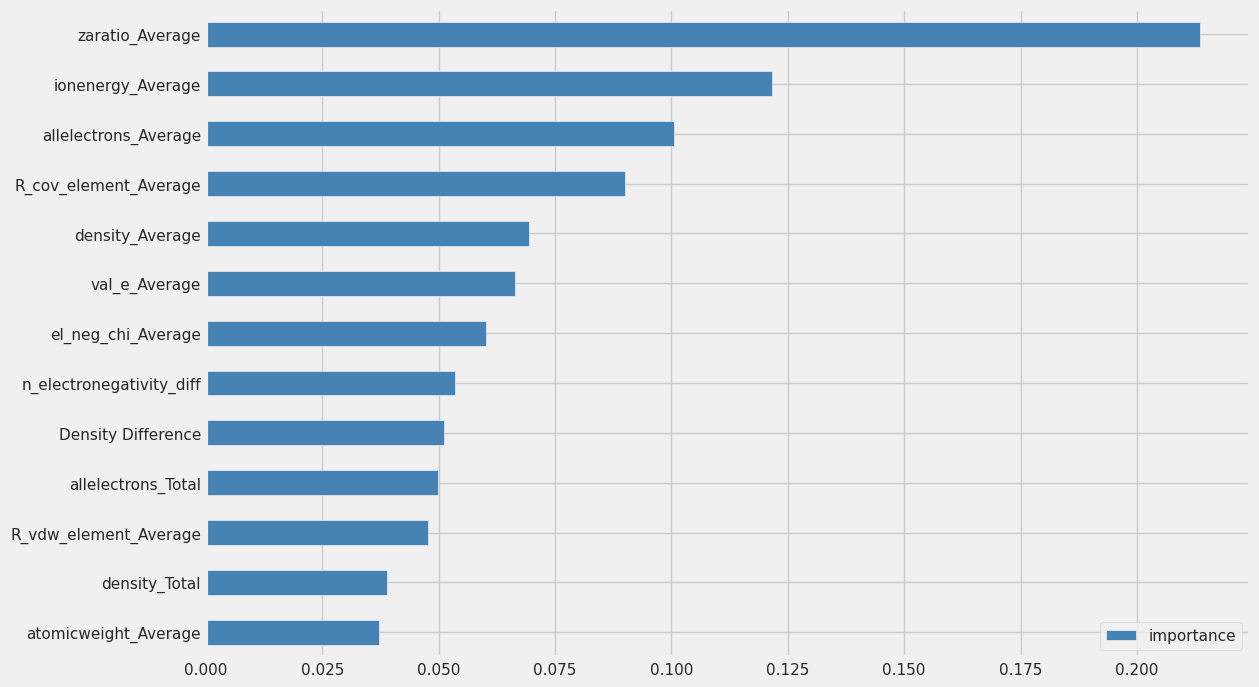

In [21]:
%%time
# I figured out best hyperparameters previously
best_forest = RandomForestRegressor(
    random_state=26,
)
    
best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='SteelBlue');


<a id='11'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧱 11 - Build a heat map of correlations</span>

In [22]:
correlation = X.corr()
correlation.style.background_gradient(cmap='coolwarm')

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,n_electronegativity_diff,Density Difference
allelectrons_Total,1.000000,0.670850,0.035905,0.075695,0.039189,0.053398,0.059447,0.010827,-0.010422,0.040268,0.021683,-0.038266,0.685214
density_Total,0.670850,1.000000,0.292719,0.074758,0.292311,-0.072341,-0.046112,0.161687,0.184837,-0.052168,0.280302,-0.291707,0.994599
allelectrons_Average,0.035905,0.292719,1.000000,0.011302,0.991049,-0.359875,-0.316275,0.553290,0.692563,-0.334412,0.809831,-0.991055,0.212445
val_e_Average,0.075695,0.074758,0.011302,1.000000,0.008661,0.452487,0.557121,0.366360,0.200237,0.081433,-0.069609,-0.001472,0.084146
atomicweight_Average,0.039189,0.292311,0.991049,0.008661,1.000000,-0.356046,-0.312833,0.531423,0.669655,-0.332467,0.802469,-0.999926,0.212823
ionenergy_Average,0.053398,-0.072341,-0.359875,0.452487,-0.356046,1.000000,0.781567,0.078179,-0.238402,0.647368,-0.363166,0.364625,-0.034875
el_neg_chi_Average,0.059447,-0.046112,-0.316275,0.557121,-0.312833,0.781567,1.000000,0.129660,-0.170562,0.445753,-0.323847,0.324394,-0.012244
R_vdw_element_Average,0.010827,0.161687,0.553290,0.366360,0.531423,0.078179,0.129660,1.000000,0.818199,-0.006734,0.445811,-0.527584,0.117509
R_cov_element_Average,-0.010422,0.184837,0.692563,0.200237,0.669655,-0.238402,-0.170562,0.818199,1.000000,-0.234917,0.578817,-0.669106,0.126855
zaratio_Average,0.040268,-0.052168,-0.334412,0.081433,-0.332467,0.647368,0.445753,-0.006734,-0.234917,1.000000,-0.311440,0.336831,-0.019792


#### <span style="color: ForestGreen">There is huge correlation between 'allelectrons_Average' and 'atomicweight_Average'. Maybe I have to drop second to avoid multicorrelation problem (second's feature importance is lower than first's)</span>

In [23]:
X = X.drop('atomicweight_Average', axis=1)
test = test.drop('atomicweight_Average', axis=1)

<a id='12'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧰 12 - Define base models</span>

In [24]:
# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

## <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;"> 12.1 PyTorch model with 3 layers</span>

In [25]:
# model = torch.nn.Sequential(
#     OrderedDict([
#         ('Linear_layer_1', torch.nn.Linear(in_features=10, out_features=16)),
#         ('ReLU_activation_1', torch.nn.ReLU()),
#         ('Linear_layer_2', torch.nn.Linear(in_features=16, out_features=32)),
#         ('ReLU_activation_2', torch.nn.ReLU()),
#         ('Linear_layer_3', torch.nn.Linear(in_features=32, out_features=64)),
#         ('ReLU_activation_3', torch.nn.ReLU()),
#         ('Linear_layer_4', torch.nn.Linear(in_features=64, out_features=1)),
#     ])
# )

# model

In [26]:
# X_np = X.values
# y_np = y.values

# # Convert NumPy arrays to PyTorch tensors
# X = torch.tensor(X_np, dtype=torch.float32, requires_grad=True)
# y = torch.tensor(y_np, dtype=torch.float32, requires_grad=True)

In [27]:
# import torch
# import torch.nn as nn

# class MedianAbsoluteError(nn.Module):
#     def __init__(self):
#         super(MedianAbsoluteError, self).__init__()

#     def forward(self, y_true, y_pred):
#         errors = torch.abs(y_true - y_pred)
#         median_error = torch.median(errors)
        
#         return median_error

    
# loss_fn = MedianAbsoluteError()

In [28]:
# %%time
# from IPython.display import clear_output

# num_epochs = 1000

# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=0.001
# )

# losses = []

# for epoch in range(1, num_epochs + 1):
#     optimizer.zero_grad()
    
#     pred = model(X)
#     loss = loss_fn(pred, y)
#     losses.append(loss.item())
    
#     loss.backward()
#     optimizer.step()
    
#     losses.append(loss.item())
    
#     if epoch % 100 == 0:
#         clear_output(True)
#         fig, ax = plt.subplots(figsize=(30, 10))
#         plt.title("Error Plot")
#         plt.plot(losses, ".-")
#         plt.xlabel("Training Iteration")
#         plt.ylabel("Error Value")
#         plt.yscale("log")
#         plt.grid()
#         plt.show()

In [29]:
# test = torch.tensor(test.values, dtype=torch.float32)

# with torch.no_grad():
#     y_pred_test = model(test)[:, 0]
#     print(y_pred_test)

## <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">12.2 Tree-based models</span>

In [30]:
# # Searching for best parameters of XGBoost
# xgb_regressor = XGBRegressor(random_state=27)

# xgb_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'learning_rate': [0.001, 0.05, 0.01],
#     'max_depth': range(2, 100, 4),
# }

# xgb_random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=xgb_parameters, n_iter=5, n_jobs=-1, cv=5, verbose=4, random_state=27)
# xgb_random_search.fit(X_val, y_val)
# print(f'Best params: {xgb_random_search.best_params_}')

{'n_estimators': 395, 'max_depth': 6, 'learning_rate': 0.01}

{'n_estimators': 395, 'max_depth': 6, 'learning_rate': 0.01}

In [31]:
# # Searching for best parameters of CatBoost
# catboost_regressor = CatBoostRegressor(random_state=27)

# catboost_parameters = {
#     'iterations': range(5, 1001, 10),
#     'learning_rate': [0.001, 0.05, 0.1],
#     'depth': range(2, 16, 2),
# }

# catboost_random_search = RandomizedSearchCV(estimator=catboost_regressor, param_distributions=catboost_parameters, n_jobs=-1, cv=5, verbose=4, random_state=27)
# catboost_random_search.fit(X_val, y_val)
# print(catboost_random_search.best_params_)

{'learning_rate': 0.05, 'iterations': 345, 'depth': 6}

{'learning_rate': 0.05, 'iterations': 345, 'depth': 6}

In [32]:
# # Searching for best parameters of LightGBM
# lgbm_regressor = LGBMRegressor(random_state=27)

# lgbm_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': range(2, 100, 2),
# }

# lgbm_random_search = RandomizedSearchCV(estimator=lgbm_regressor, param_distributions=lgbm_parameters, n_jobs=-1, cv=5, verbose=4, random_state=27)
# lgbm_random_search.fit(X_val, y_val)
# print(lgbm_random_search.best_params_)

{'n_estimators': 375, 'max_depth': 86, 'learning_rate': 0.01}

{'n_estimators': 375, 'max_depth': 86, 'learning_rate': 0.01}

In [33]:
# # Searching for best parameters of RandomForestRegressor
# random_regressor = RandomForestRegressor(random_state=27)

# param_dist = {
#     'n_estimators': range(5, 1001, 10),
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [int(x) for x in np.linspace(10, 110, num=21)],
#     'min_samples_split': range(2, 101, 2),
#     'min_samples_leaf': range(2, 101, 2),
#     'bootstrap': [True, False]
# }

# random_search = RandomizedSearchCV(estimator=random_regressor, param_distributions=param_dist, n_jobs=-1, cv=5, verbose=4, random_state=27)
# random_search.fit(X_val, y_val)
# print(random_search.best_params_)

{'n_estimators': 115, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}

{'n_estimators': 115,
 'min_samples_split': 6,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [34]:
# # Searching for best parameters of HistGradientBoostingRegressor
# HGB_regressor = HistGradientBoostingRegressor(random_state=27)

# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_iter': range(25, 1001, 25),
#     'max_depth': range(3, 100, 2),
#     'min_samples_leaf': range(2, 101, 2),
# }

# random_search = RandomizedSearchCV(estimator=HGB_regressor, param_distributions=param_dist, n_jobs=-1, cv=5, verbose=4, random_state=27)
# random_search.fit(X_val, y_val)
# best_params = random_search.best_params_
# print(best_params)

{'min_samples_leaf': 32, 'max_iter': 625, 'max_depth': 27, 'learning_rate': 0.01}

{'min_samples_leaf': 32,
 'max_iter': 625,
 'max_depth': 27,
 'learning_rate': 0.01}

In [35]:
# # Searching for best parameters of ExtraTreesRegressor
# ETR_regressor = ExtraTreesRegressor(random_state=27)

# param_dist = {
#     'n_estimators': range(5, 1001, 10),
#     'max_depth': range(2, 100, 2),
#     'min_samples_leaf': range(2, 101, 2),
# }

# ETR = RandomizedSearchCV(estimator=ETR_regressor, param_distributions=param_dist, n_jobs=-1, cv=5, verbose=4, random_state=27)
# ETR.fit(X_val, y_val)
# best_params = ETR.best_params_
# print(best_params)

{'n_estimators': 255, 'min_samples_leaf': 12, 'max_depth': 40}

{'n_estimators': 255, 'min_samples_leaf': 12, 'max_depth': 40}

In [36]:
# # Searching for best parameters of AdaBoostRegressor
# AdaBoost_regressor = AdaBoostRegressor(random_state=27)

# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': range(5, 1001, 10),
# }

# AdaBoost = RandomizedSearchCV(estimator=AdaBoost_regressor, param_distributions=param_dist, n_jobs=-1, cv=5, verbose=4, random_state=27)
# AdaBoost.fit(X_val, y_val)
# best_params = AdaBoost.best_params_
# print(best_params)

{'n_estimators': 65, 'learning_rate': 0.05}

{'n_estimators': 65, 'learning_rate': 0.05}

In [37]:
# # Searching for best parameters of BaggingRegressor
# Bagging_regressor = BaggingRegressor(random_state=27)

# param_dist = {
#     'n_estimators': range(5, 1001, 10)
# }

# bagging = RandomizedSearchCV(estimator=Bagging_regressor, param_distributions=param_dist, n_jobs=-1, cv=5, verbose=4, random_state=27)
# bagging.fit(X_val, y_val)
# best_params = bagging.best_params_
# print(best_params)

{'n_estimators': 275}

{'n_estimators': 275}

In [38]:
# # Searching for best parameters of GradientBoostingRegressor
# GB_regressor = GradientBoostingRegressor(random_state=27)

# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': range(25, 1001, 25),
#     'max_depth': range(2, 100, 2),
#     'min_samples_leaf': range(2, 100, 2)
# }

# gb = RandomizedSearchCV(estimator=GB_regressor, param_distributions=param_dist, n_jobs=-1, cv=5, verbose=4, random_state=27)
# gb.fit(X_val, y_val)
# best_params = gb.best_params_
# print(best_params)

{'n_estimators': 400, 'min_samples_leaf': 86, 'max_depth': 26, 'learning_rate': 0.01}

{'n_estimators': 400,
 'min_samples_leaf': 86,
 'max_depth': 26,
 'learning_rate': 0.01}

In [39]:
# I'm 27 years old, that's why I use random_state=27
base_models = [
    ('Catboost', CatBoostRegressor(
        iterations=345,
        learning_rate=0.05,
        depth=6,
        random_state=27
    )),
    ('XGBoost', XGBRegressor(
        n_estimators=395,
        learning_rate=0.01,
        max_depth=6,
        random_state=27
    )),
    ('LightGBM', LGBMRegressor(
        n_estimators=375,
        learning_rate=0.01,
        max_depth=86,
        random_state=27
    )),
    ('RandomForest', RandomForestRegressor(
        n_estimators=115,
        min_samples_split=6,
        min_samples_leaf=10,
        max_features='sqrt',
        max_depth=70,
        bootstrap=False,
        random_state=27
    )),
    ('HistGradientBoostingRegressor', HistGradientBoostingRegressor(
        min_samples_leaf=32,
        max_iter=625,
        max_depth=27,
        learning_rate=0.01
    )),
    ('ExtraTreesRegressor', ExtraTreesRegressor(
        n_estimators=255, 
        min_samples_leaf=12, 
        max_depth=40
    )),
    ('AdaBoostRegressor', AdaBoostRegressor(
        n_estimators=65, 
        learning_rate=0.05
    )),
    ('BaggingRegressor', BaggingRegressor(
        n_estimators=275
    )),
    ('GradientBoostingRegressor', GradientBoostingRegressor(
        n_estimators=400, 
        min_samples_leaf=86, 
        max_depth=26,
        learning_rate=0.01
    ))
]

<a id='13'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🔨 13 - Defining the meta-model</span>

In [40]:
meta_model = CatBoostRegressor(
    iterations=345,
    learning_rate=0.05,
    depth=6,
    random_state=27
)

![](https://laboratuar.com/images/iso-11125-2-metalik-puskurtmeli-temizleme-asindiricilari-icin-test-yontemleri---parcacik-boyutu-dagiliminin-belirlenmesi.jpg)

<a id='14'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">💎 14 - Creating and fitting the stacking model

In [41]:
%%time
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

0:	learn: 1.6560332	total: 60.2ms	remaining: 20.7s
1:	learn: 1.6320295	total: 64.1ms	remaining: 11s
2:	learn: 1.6068924	total: 68.2ms	remaining: 7.78s
3:	learn: 1.5832557	total: 72.2ms	remaining: 6.16s
4:	learn: 1.5636287	total: 76.2ms	remaining: 5.18s
5:	learn: 1.5442126	total: 80.1ms	remaining: 4.52s
6:	learn: 1.5265088	total: 84.4ms	remaining: 4.08s
7:	learn: 1.5107194	total: 88.3ms	remaining: 3.72s
8:	learn: 1.4941071	total: 92ms	remaining: 3.43s
9:	learn: 1.4793569	total: 96.3ms	remaining: 3.22s
10:	learn: 1.4660075	total: 99.8ms	remaining: 3.03s
11:	learn: 1.4534405	total: 103ms	remaining: 2.87s
12:	learn: 1.4411887	total: 107ms	remaining: 2.73s
13:	learn: 1.4298499	total: 110ms	remaining: 2.61s
14:	learn: 1.4199510	total: 114ms	remaining: 2.5s
15:	learn: 1.4096295	total: 117ms	remaining: 2.41s
16:	learn: 1.4014004	total: 121ms	remaining: 2.33s
17:	learn: 1.3933506	total: 124ms	remaining: 2.26s
18:	learn: 1.3864600	total: 128ms	remaining: 2.19s
19:	learn: 1.3791888	total: 131ms	r

StackingRegressor(estimators=[('Catboost',
                               <catboost.core.CatBoostRegressor object at 0x7faef53d8250>),
                              ('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_...
                                                   n_estimators=255)),
                              ('AdaBoostRegressor',
                               AdaBoostRegressor(learning_rate=0.05,
                                                 n_estimators=65)),
                              ('BaggingRegressor',
                               BaggingRegressor(n_estimators=275)),
                              ('GradientBoostingRegressor',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=26,
                                                         min_samples_leaf=86,
                                                         n_estimators=400))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x7faef53d9cc0>)

<a id='15'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🏭 15 - Predict the validation set and calculate Median Absolute Error score</span>

In [42]:
y_pred_val = stacking_model.predict(X_val)

medae_val = median_absolute_error(y_val, y_pred_val)
print(f"Validation Median Absolute Error: {medae_val:.8f}")

Validation Median Absolute Error: 0.45007072


<a id='16'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧱 16 - Predict on the test data</span>

In [43]:
y_pred_test = stacking_model.predict(test)
y_pred_test[:10]

array([2.69125801, 2.91317887, 5.5367744 , 4.3906567 , 5.09097876,
       4.78439919, 3.72653954, 5.03345821, 3.13673446, 4.7644889 ])

<a id='17'></a>
# <span style="color: red; border-bottom: 6px solid orange; background-color: #fadb8c;">🧰 17 - Build DataFrame and make first submission</span>

In [44]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'Hardness': y_pred_test
})

submission.to_csv('Kapturov_S3E25_submission.csv', index=False)
submission.head(10)

,id,Hardness
0,10407,2.691258
1,10408,2.913179
2,10409,5.536774
3,10410,4.390657
4,10411,5.090979
5,10412,4.784399
6,10413,3.726540
7,10414,5.033458
8,10415,3.136734
9,10416,4.764489


![](https://terracotta.by/upload/iblock/626/2mbuqiuhyl9bywxjpyysgyu35k2r9i1u.jpg)